In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from utils import get_images_labels, match_label_fou_clean2, match_label_video, read_mean_std, fold_batches
from utils import imread_rgb, mean_avg_precision, avg_precision, scale_cv
from model.nn_utils import *
from model.siamese import *
from model.custom_modules import *
from os import path
import cv2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [ ]:
# first section: test feature net on a given dataset (print avg precision values/mAP etc.)

In [10]:
trainSetPath = 'data/pre_proc/CLICIDE_video_224sq'
testSetPath = 'data/pre_proc/CLICIDE_video_224sq/test'
mean_std_file = 'data/CLICIDE_224sq_train_ms.txt'
image_size = (3, 224, 224)
fit_size = True
cnn_model = models.resnet152
feature_size = (7, 7)
out_size = 1000 # 7 * 7 * 2048  # 6 * 6 * 256
conv_features = False

In [11]:
m, s = read_mean_std(mean_std_file)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(m, s)])

def get_embeddings(net, dataset, out_size):
    C, H, W = image_size

    def batch(last, i, is_final, batch):
        embeddings = last
        n = len(batch)
        test_in = torch.Tensor(n, C, H, W).cuda()
        for j in range(n):
            test_in[j] = batch[j][0]

        out = net(Variable(test_in, volatile=True))
        out = out.view(out.size(0), out_size)
        for j, o in enumerate(out.data):
            embeddings[i + j] = o / (o.norm() + 1e-10)
        return embeddings
    init = torch.Tensor(len(dataset), out_size)
    return fold_batches(batch, init, dataset, 32)

def pre_proc(im_o):
    if fit_size:
        im_o = cv2.resize(im_o, (image_size[1], image_size[2]), cv2.INTER_CUBIC)
    return im_o

In [30]:
trainSetFull = get_images_labels(trainSetPath, match_label_video)
testSetFull = get_images_labels(testSetPath, match_label_video)

labels = sorted(list(set(lab for im, lab in trainSetFull)))
print(len(trainSetFull), len(testSetFull), len(labels))
print(labels)

(3245, 177, 464)
['10A', '10B', '10C', '10D', '10E', '10F', '10G', '10H', '10I', '10J', '11A', '11B', '11C', '11D', '11E', '11F', '11G', '11H', '11I', '11J', '11K', '11L', '11M', '11N', '11O', '12A', '12B', '12C', '12D', '12E', '12F', '12G', '12H', '12I', '12J', '12K', '12O', '12P', '13A', '13C', '13D', '13E', '13G', '13H', '14B', '14C', '14D', '14E', '14F', '14G', '14H', '14I', '14J', '14K', '14L', '14M', '15A', '15B', '15C', '15D', '15E', '15F', '15G', '15J', '15K', '15L', '15N', '15O', '15P', '15Q', '15R', '15S', '15T', '16A', '16B', '16C', '16D', '16E', '16F', '16G', '16H', '16I', '16J', '16K', '16L', '16M', '16N', '16O', '16P', '16Q', '17A', '17B', '17C', '17D', '17E', '17F', '17G', '17H', '17I', '17J', '17K', '17L', '17M', '17N', '1A', '1B', '1C', '1D', '1E', '1F', '1G', '1H', '1I', '1J', '1K', '1L', '1M', '1N', '1O', '1P', '1Q', '1R', '20A', '20B', '20C', '20D', '20E', '20F', '20G', '20H', '20I', '20J', '20K', '20L', '20M', '20N', '21A', '21B', '21C', '21D', '21E', '21F', '21G',

In [7]:
trainSet, testSet = [], []
for im, lab in trainSetFull:
    im_o = pre_proc(imread_rgb(im))
    if lab in labels:
        im_out = trans(im_o)
        trainSet.append((im_out, lab, im))
for im, lab in testSetFull:
    im_o = pre_proc(imread_rgb(im))
    if lab in labels:
        im_out = trans(im_o)
        testSet.append((im_out, lab, im))
print(len(trainSet))
print(len(testSet))

3245
165


In [8]:
feature_net = cnn_model(pretrained=True)
if conv_features and isinstance(feature_net, TuneClassif):
    feature_net.classifier = nn.Sequential()
    feature_net.feature_reduc = nn.Sequential()
elif conv_features and (cnn_model is models.resnet152 or cnn_model is models.resnet101):
    feature_net.avgpool = nn.Sequential()
    feature_net.fc = nn.Sequential()
elif conv_features:
    feature_net.classifier = nn.Sequential()
feature_net = feature_net.cuda().eval()

In [13]:
test_embeddings = get_embeddings(feature_net, testSet, out_size)
ref_embeddings = get_embeddings(feature_net, trainSet, out_size)
sim = torch.mm(test_embeddings, ref_embeddings.t())
maxSim, maxIdx = sim.max(1)
maxLabel = []
for i in maxIdx:
    # get label from ref set which obtained highest score
    maxLabel.append(trainSet[i[0]][1])
correct = sum(testLabel == maxLabel[j] for j, (_, testLabel, _) in enumerate(testSet))
total = len(testSet)

In [17]:
print(correct, '/', total, '->', float(correct)/total)
print(mean_avg_precision(sim, testSet, trainSet))
for i in range(sim.size(0)):
    print(testSet[i][1], avg_precision(sim, i, testSet, trainSet), sum(testSet[i][1] == trainLab for _, trainLab, _ in trainSet))

(106, '/', 165, '->', 0.6424242424242425)
0.315586555614
('10A', 0.33085317460317454, 4)
('10C', 0.04953938429638845, 8)
('10J', 0.22865674508007558, 11)
('10J', 0.344987240863682, 11)
('11A', 0.2714499971758117, 10)
('11C', 0.003200937852420862, 5)
('11C', 0.701005291005291, 5)
('11F', 0.12372996657400451, 10)
('11J', 0.8178039215686275, 5)
('11O', 0.00405372169203168, 5)
('12A', 0.5374120434126828, 10)
('12D', 0.38979162326597544, 3)
('12E', 0.10045822140260237, 10)
('12F', 0.15533842138615572, 8)
('12G', 0.3800110337979898, 14)
('12G', 0.14060448682108817, 14)
('12G', 0.0033578123702988866, 14)
('12I', 0.4128973143111086, 10)
('12K', 0.17647147490896736, 6)
('12P', 0.10484610550538978, 14)
('12P', 0.37521109916548123, 14)
('13A', 0.002185663709490024, 10)
('14M', 0.43883334453898554, 5)
('15F', 0.7514285714285713, 5)
('15G', 0.5161396156952899, 5)
('16C', 0.00387619265503143, 10)
('16F', 0.1959031642756657, 10)
('16O', 0.16404465342641644, 10)
('1C', 0.00328856143650887, 5)
('1F', 0

In [ ]:
# in this section: output embeddings conforming to gordo's test program

In [18]:
import numpy as np
import os
out_size = 464

In [19]:
full_dataset_path = '../gordo_retrieval/datasets/CLICIDE/jpg'
queries_path = '../gordo_retrieval/datasets/CLICIDE/lab'
queries = []
for e in np.sort(os.listdir(queries_path)):
    if e.endswith('_query.txt'):
        queries.append(e[:-len('_query.txt')])
queries = sorted(queries)
full_dataset, ref_dataset = [], []
for im in np.sort(os.listdir(full_dataset_path)):
    im_o = trans(pre_proc(imread_rgb(path.join(full_dataset_path, im))))
    lab = im.split('/')[-1].split('-')[0]
    full_dataset.append((im_o, lab))
    if im.split('/')[-1].split('.')[0] not in queries:
        ref_dataset.append((im_o, lab, im))
query_set = []
for name in queries:
    im_o = trans(pre_proc(imread_rgb(path.join(full_dataset_path, name + '.jpg'))))
    query_set.append((im_o, name.split('-')[0], name))

In [22]:
class_net = TuneClassif(cnn_model(pretrained=True), len(labels), untrained=49)
class_net.load_state_dict(torch.load('data/finetune_classif/cli_best_resnet152_classif_finetuned.pth.tar'))
class_net.cuda().eval()
query_embeddings = get_embeddings(class_net, query_set, out_size)
dataset_embeddings = get_embeddings(class_net, full_dataset, out_size)
ref_embeddings = get_embeddings(class_net, ref_dataset, out_size)
np.save('data/CLICIDE_S800_L2_queries.npy', query_embeddings.numpy())
np.save('data/CLICIDE_S800_L2_dataset.npy', dataset_embeddings.numpy())

In [23]:
sim = torch.mm(query_embeddings, ref_embeddings.t())
print(mean_avg_precision(sim, query_set, ref_dataset))
for i in range(sim.size(0)):
    print(query_set[i][1], avg_precision(sim, i, query_set, ref_dataset), sum(query_set[i][1] == ref_label for _, ref_label, _ in ref_dataset))

ValueError: need more than 2 values to unpack

In [27]:
# in this section: visualize maximal activations of a fine-tuned classification net

In [28]:
feature_net1 = TuneClassif(cnn_model(pretrained=True), len(labels), untrained=49)
feature_net1.load_state_dict(torch.load('data/finetune_classif/cli_best_resnet152_classif_finetuned.pth.tar'))
feature_net1 = feature_net1.eval().cuda()
feature_net2 = TuneClassif(cnn_model(pretrained=True), len(labels), untrained=49)
feature_net2.load_state_dict(torch.load('data/finetune_classif/cli_best_resnet152_classif_finetuned.pth.tar'))
feature_net2.feature_reduc = nn.Sequential(nn.AvgPool2d(7, stride=1))
feature_net2.classifier = convolutionalize(feature_net2.classifier[0], (1, 1))
feature_net2 = feature_net2.eval().cuda()

In [31]:
test_img = '/video/CLICIDE/test/30P-0976.JPG'
test_label = test_img.split('/')[-1].split('-')[0]
test_tensor = torch.Tensor(1, 3, 224, 224).cuda()
test_tensor[0] = trans(cv2.resize(imread_rgb(test_img), (224, 224), cv2.INTER_CUBIC))
test_out = feature_net1(Variable(test_tensor, volatile=True))
print(test_out.data.max(1))

sc = scale_cv(448)
img = trans(sc(imread_rgb(test_img)))
in_tensor = torch.Tensor(1, *img.size()).cuda()
in_tensor[0] = img
print(test_label, labels.index(test_label), in_tensor.size())
out1 = feature_net2.features(Variable(in_tensor, volatile=True))
print(out1.size())
out2 = feature_net2.feature_reduc(out1)
out3 = feature_net2.classifier(out2)
max_v, max_l = out3.data.max(1)
print(max_v.size(), max_l.size())

(
 7.9815
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]
, 
 266
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
)
('30P', 265, torch.Size([1, 3, 597, 448]))
torch.Size([1, 2048, 19, 14])
(torch.Size([1, 1, 13, 8]), torch.Size([1, 1, 13, 8]))


In [32]:
max_values = max_v.view(max_v.size(2), max_v.size(3)).cpu().numpy()
cmap = plt.cm.get_cmap('Paired', len(labels) + 1)
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[len(labels)] = (.0, .0, .0, .0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
max_labels = max_l.view(max_l.size(2), max_l.size(3)).cpu().numpy()
# all labels where the max value is too small are ignored
max_labels[max_values < np.mean(max_values)] = len(labels)
labels_set = np.array(sorted(list(set(max_labels.flatten()))))

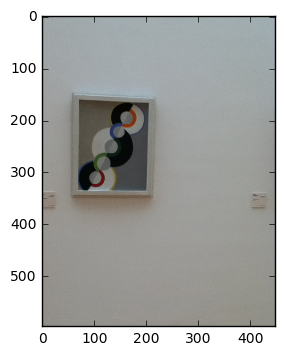

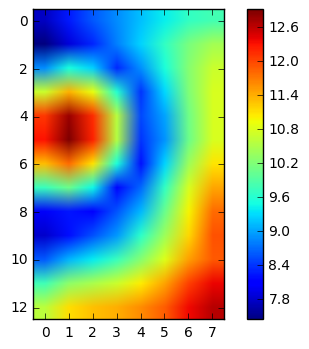

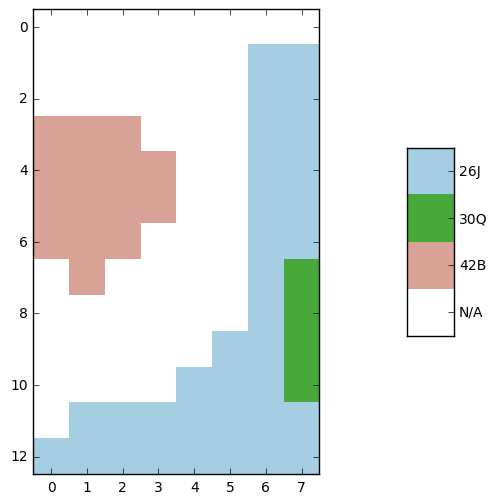

In [33]:
plt.imshow(sc(imread_rgb(test_img)))
plt.savefig('sample1_10A-0519.png', bbox_inches='tight')

fig, ax = plt.subplots()
cax = ax.imshow(max_values)
fig.colorbar(cax)
plt.savefig('sample1_heatmap.png', bbox_inches='tight')

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 1])
ax1 = plt.subplot(gs[0])
ax1.imshow(max_labels, cmap, interpolation='nearest')
ax2 = plt.subplot(gs[1])
ax2.imshow(labels_set[:, np.newaxis], cmap, interpolation='nearest')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().tick_right()
ax2.set_yticks(range(len(labels_set)))
ax2.set_yticklabels([labels[lab] if lab < len(labels) else 'N/A' for lab in labels_set])

plt.savefig('sample1_labels.png', bbox_inches='tight')

In [35]:
class_net = TuneClassifSub(models.resnet152(pretrained=True), 464, (7, 7))
class_net.load_state_dict(torch.load('data/final_classif_sub/cli_resnet152.pth.tar'))
class_net = class_net.eval().cuda()

total, correct = 0, 0

for i, (im, lab, _) in enumerate(testSet):
    t = im.unsqueeze(0).cuda()
    out = class_net(Variable(t))[0].data
    max_pred, predicted = torch.max(out, 1)
    _, max_subp = torch.max(max_pred.view(-1), 0)
    predicted = predicted.view(-1)[max_subp[0]]
    total += 1
    correct += (labels.index(lab) == predicted)
    if labels.index(lab) != predicted:
        count = 0
        for j, (im, lab) in enumerate(testSetFull):
            if lab not in labels:
                count += 1
            if i + count == j:
                break
        print(lab, i, i + count, testSetFull[i + count])
print(correct, total)

('11C', 5, 5, ('data/pre_proc/CLICIDE_video_224sq/test/11C-0351.JPG', '11C'))
('11O', 9, 9, ('data/pre_proc/CLICIDE_video_224sq/test/11O-0438.JPG', '11O'))
('12D', 11, 11, ('data/pre_proc/CLICIDE_video_224sq/test/12D-0347.JPG', '12D'))
('12G', 16, 16, ('data/pre_proc/CLICIDE_video_224sq/test/12G-0428.JPG', '12G'))
('15F', 23, 23, ('data/pre_proc/CLICIDE_video_224sq/test/15F-0336.JPG', '15F'))
('16C', 25, 25, ('data/pre_proc/CLICIDE_video_224sq/test/16C-0343.JPG', '16C'))
('1C', 28, 28, ('data/pre_proc/CLICIDE_video_224sq/test/1C-0454.JPG', '1C'))
('1F', 29, 29, ('data/pre_proc/CLICIDE_video_224sq/test/1F-0452.JPG', '1F'))
('1R', 38, 38, ('data/pre_proc/CLICIDE_video_224sq/test/1R-0446.JPG', '1R'))
('20L', 44, 44, ('data/pre_proc/CLICIDE_video_224sq/test/20L-0731.JPG', '20L'))
('21D', 50, 50, ('data/pre_proc/CLICIDE_video_224sq/test/21D-0744.JPG', '21D'))
('22C', 52, 53, ('data/pre_proc/CLICIDE_video_224sq/test/22C-0814.JPG', '22C'))
('22D', 53, 54, ('data/pre_proc/CLICIDE_video_224sq/t